**Q12**: Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

**A12**: 

This problem required me looking up the solution from the book. I ran through it myself to make sure I understood.

let's start by loading the data:

In [7]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
print(iris.feature_names)
print(iris.target_names)
print("data:")
print(iris.data[:5])
print("target:")
print(iris.target[:5])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
data:
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
target:
[0 0 0 0 0]


In [2]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
print(X[:5])

[[ 1.4  0.2]
 [ 1.4  0.2]
 [ 1.3  0.2]
 [ 1.5  0.2]
 [ 1.4  0.2]]


In [10]:
# apparently we need to add a bias term of one to each entry. Not sure why..
X_with_bias = np.c_[np.ones([len(X), 1]), X]
X_with_bias[:5]

array([[ 1. ,  1.4,  0.2],
       [ 1. ,  1.4,  0.2],
       [ 1. ,  1.3,  0.2],
       [ 1. ,  1.5,  0.2],
       [ 1. ,  1.4,  0.2]])

In [11]:
# let's use a constant seed for consistent results
np.random.seed(2042)

Let's separate our data into training, test, and validation sets. 

We could do this `using train_test_split()`, but we want to do this all ourselves, so...

In [12]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The labels are 0, 1 or 2 to represent the class. We need these as probability vectors, so here's what the data looks like originally:

In [21]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

now we can write a one-hot encoder, and see what it looks like when run through that.

In [24]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

to_one_hot(y_train[:10])

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

looks good, let's created target matrices for all sets:

In [25]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Cool! Now we can implement softmax function:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$



In [28]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

let's count the number of inputs/outputs

In [31]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
print(n_inputs)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)
print(n_outputs)

3
3


So the equations we will need are the cost function:

$J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting nan values.

So then it's just a matter of coding this shit up!

In [32]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.44618386482
500 0.835100303577
1000 0.687696155441
1500 0.601029983545
2000 0.544278281196
2500 0.503726274224
3000 0.472835729391
3500 0.448187250818
4000 0.427834726281
4500 0.410589102282
5000 0.395680325749


The softmax model is trained! Let's inspect Theta:

In [34]:
Theta

array([[ 3.3172417 , -0.6476445 , -2.99855999],
       [-1.16505434,  0.11283387,  0.10251113],
       [-0.72087779, -0.083875  ,  1.48587045]])

let's make predictions and check our accuracy:

In [36]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.96666666666666667

let's try adding some l2 regularization:

In [38]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.62957494791
500 0.534163155437
1000 0.503771274864
1500 0.494805645558
2000 0.491408194841
2500 0.490008507445
3000 0.489407428961
3500 0.489143102469
4000 0.489025165491
4500 0.488972058096
5000 0.488948000479


In [39]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

perfect! Now let's add some early stopping:

In [40]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.70940845273
500 0.574099607346
1000 0.543638281366
1500 0.535638768431
2000 0.533256378917
2500 0.532654427178
2765 0.532605822457
2766 0.532605823051 early stopping!


In [41]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

still perfect! Let's plot this baby:

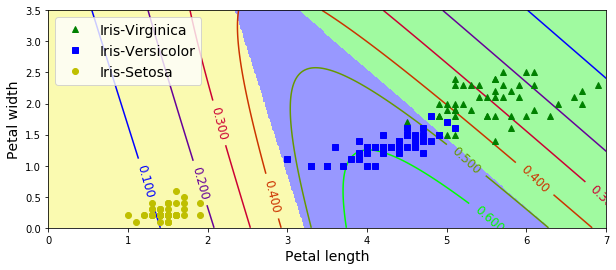

In [44]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

and let's check the model's accuracy on the test set:

In [45]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.93333333333333335

not bad, apparently there is a quite a bit of variability depending on the training, validation and test set.